In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cluster import DBSCAN

In [5]:
from tpot.builtins import StackingEstimator

In [6]:
from sklearn.cluster import KMeans

In [7]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [8]:
parse_dates = ['created_at']

In [9]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [11]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [12]:
df.isnull().sum()

order_id                    0
ride_id                     0
created_at                  0
pickup_lat                565
pickup_lon                565
dropoff_lat               780
dropoff_lon               780
user_id                378190
driver_id                   0
ride_distance               0
ooCancelReason              0
ooSuburbanDistance          0
ooCarSearchTime             0
ooCost                      0
ooExtraCost                 0
ooInitialCost               0
ooIdleCost                  0
oapAzureMlCost        1521212
oapAzureMlCostBid     1521212
oapCostProvider       1350984
ooSurgeMultiplier           0
driver_lat             417486
driver_lon             417486
dtTaxiDriver_tdID      417486
dtype: int64

In [13]:
df.shape

(2815393, 24)

In [14]:
df = df.sample(n=300000)

In [15]:
df.shape

(300000, 24)

In [16]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon'],inplace=False)

In [17]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [18]:
new_df.shape

(252589, 24)

In [19]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost','pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','ooIdleCost']]

In [20]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost
533572,2017-10-15 11:39:06.723,9.91,0,7,89.0,50.520004,30.461023,50.494019,30.363171,0.0
869547,2017-10-05 20:42:47.080,10.23,0,7,93.0,50.466591,30.515554,50.398354,30.497868,0.0
150162,2017-10-27 17:55:19.110,5.42,0,11,116.0,50.467556,30.485859,50.435810,30.509760,0.0
1236615,2017-09-23 20:04:50.207,14.42,0,1,113.0,50.493305,30.558781,50.408367,30.624395,0.0
356759,2017-10-21 02:04:35.750,18.07,0,38,135.0,50.421543,30.553041,50.510326,30.489574,0.0


In [21]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
pickup_lat            0
pickup_lon            0
dropoff_lat           0
dropoff_lon           0
ooIdleCost            0
dtype: int64

In [22]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)
data['date'] = data['created_at'].dt.strftime('%Y-%m-%d')

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [23]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [24]:
dt = {'date': ['2017-08-24', '2017-10-14'], 
        'isHolidays': [1, 1]}
holidays = pd.DataFrame(dt, columns = ['date', 'isHolidays'])

In [25]:
data = pd.merge(data, holidays, on='date', how='left')

In [26]:
data['isHolidays'].fillna(value=0, inplace=True)

In [27]:
data.shape

(252589, 22)

### Clusterization

In [28]:
pickup_coords = data.loc[:,['pickup_lat','pickup_lon']]
dropoff_coords = data.loc[:,['dropoff_lat','dropoff_lon']]

In [29]:
num_pickup_clusters = 7
num_dropoff_clusters = 7

In [30]:
pickup_kmeans = KMeans(n_clusters=num_pickup_clusters, random_state=1).fit(pickup_coords)

In [31]:
dropoff_kmeans = KMeans(n_clusters=num_dropoff_clusters, random_state=1).fit(dropoff_coords)

In [32]:
id_pickup_label=pickup_kmeans.labels_
id_dropoff_label=dropoff_kmeans.labels_

In [33]:
id_pickup_label.shape, id_dropoff_label.shape

((252589,), (252589,))

In [34]:
data['pickup_cluster'] = id_pickup_label
data['dropoff_cluster'] = id_dropoff_label

In [35]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost,...,hour,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,pickup_cluster,dropoff_cluster
0,2017-10-15 11:39:06.723,9.91,0,7,89.0,50.520004,30.461023,50.494019,30.363171,0.0,...,11,2017-10-15,4,10,15,6,11,0.0,0,0
1,2017-10-05 20:42:47.080,10.23,0,7,93.0,50.466591,30.515554,50.398354,30.497868,0.0,...,20,2017-10-05,4,10,5,3,20,0.0,3,3
2,2017-10-27 17:55:19.110,5.42,0,11,116.0,50.467556,30.485859,50.435810,30.509760,0.0,...,17,2017-10-27,4,10,27,4,17,0.0,0,3
3,2017-09-23 20:04:50.207,14.42,0,1,113.0,50.493305,30.558781,50.408367,30.624395,0.0,...,20,2017-09-23,3,9,23,5,20,0.0,5,6
4,2017-10-21 02:04:35.750,18.07,0,38,135.0,50.421543,30.553041,50.510326,30.489574,0.0,...,2,2017-10-21,4,10,21,5,2,0.0,3,5


In [36]:
data.tail()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost,...,hour,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,pickup_cluster,dropoff_cluster
252584,2017-09-27 08:49:04.463,5.50,0,65,80.0,50.429779,30.484997,50.462891,30.508522,0.0,...,8,2017-09-27,3,9,27,2,8,0.0,3,3
252585,2017-08-23 20:11:03.160,5.62,0,8,83.0,50.432079,30.512758,50.393467,30.500957,0.0,...,20,2017-08-23,3,8,23,2,20,0.0,3,3
252586,2017-09-14 13:58:43.283,4.91,0,2,65.0,50.419601,30.521631,50.429951,30.492132,0.0,...,13,2017-09-14,3,9,14,3,13,0.0,3,3
252587,2017-10-07 21:50:05.760,2.45,0,6,47.0,50.473900,30.448599,50.486679,30.461111,0.0,...,21,2017-10-07,4,10,7,5,21,0.0,0,5
252588,2017-09-21 17:27:06.877,8.67,0,84,85.0,50.377016,30.475905,50.425870,30.542498,0.0,...,17,2017-09-21,3,9,21,3,17,0.0,1,3


In [37]:
data.shape

(252589, 24)

In [38]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,pickup_cluster,dropoff_cluster
count,252589.00000,252589.0,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000,252589.000000
mean,11.05635,0.0,19.008262,105.358986,50.446200,30.513616,50.446050,30.514176,0.423811,3.362724,9.051083,15.849059,3.011501,13.362336,0.022309,2.422809,3.089774
std,7.23304,0.0,28.192796,49.961335,0.038580,0.082945,0.040640,0.088938,3.333204,0.480787,0.819608,8.862059,1.955006,6.562452,0.147687,1.490563,1.785891
min,0.00000,0.0,-3515.000000,40.000000,50.106449,29.949812,50.089516,29.917574,0.000000,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.61000,0.0,5.000000,70.000000,50.422974,30.466961,50.421444,30.464724,0.000000,3.000000,8.000000,8.000000,1.000000,9.000000,0.000000,1.000000,2.000000
50%,9.97000,0.0,9.000000,100.000000,50.442612,30.510380,50.442226,30.509151,0.000000,3.000000,9.000000,16.000000,3.000000,14.000000,0.000000,3.000000,3.000000
75%,14.50000,0.0,23.000000,125.000000,50.465675,30.546051,50.467125,30.555006,0.000000,4.000000,10.000000,23.000000,5.000000,19.000000,0.000000,3.000000,5.000000
max,117.71000,0.0,2565.000000,1057.000000,50.812706,30.974821,50.812706,30.981932,285.000000,4.000000,10.000000,31.000000,6.000000,23.000000,1.000000,6.000000,6.000000


In [39]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [40]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek', 'pickup_cluster', 'dropoff_cluster']

In [41]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [42]:
# let's check
df_cat.head()

,pickup_cluster,dropoff_cluster,quarter_3,quarter_4,month_10,month_8,month_9,day_1,day_10,day_11,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,3,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,3,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5,6,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3,5,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [44]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-15 11:39:06.723,9.91,0,7,89.0,50.520004,30.461023,50.494019,30.363171,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2017-10-05 20:42:47.080,10.23,0,7,93.0,50.466591,30.515554,50.398354,30.497868,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2017-10-27 17:55:19.110,5.42,0,11,116.0,50.467556,30.485859,50.435810,30.509760,0.0,...,0,0,0,0,0,0,0,1,0,0
3,2017-09-23 20:04:50.207,14.42,0,1,113.0,50.493305,30.558781,50.408367,30.624395,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2017-10-21 02:04:35.750,18.07,0,38,135.0,50.421543,30.553041,50.510326,30.489574,0.0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [46]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,ooIdleCost,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-15 11:39:06.723,9.91,0,7,89.0,50.520004,30.461023,50.494019,30.363171,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2017-10-05 20:42:47.080,10.23,0,7,93.0,50.466591,30.515554,50.398354,30.497868,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2017-10-27 17:55:19.110,5.42,0,11,116.0,50.467556,30.485859,50.435810,30.509760,0.0,...,0,0,0,0,0,0,0,1,0,0
3,2017-09-23 20:04:50.207,14.42,0,1,113.0,50.493305,30.558781,50.408367,30.624395,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2017-10-21 02:04:35.750,18.07,0,38,135.0,50.421543,30.553041,50.510326,30.489574,0.0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int']

In [48]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [49]:
# split features and target
dfX = data.drop(['pickup_lat','pickup_lon','dropoff_lat','dropoff_lon','created_at','date','ooCost'], axis=1)
dfY = data['ooCost']

In [50]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooIdleCost,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.084190,0.0,0.579276,0.0,11,1.0,1.0,0.466667,1.000000,11,...,0,0,0,0,0,0,0,0,0,1
1,0.086909,0.0,0.579276,0.0,20,1.0,1.0,0.133333,0.500000,20,...,0,0,0,0,0,0,1,0,0,0
2,0.046045,0.0,0.579934,0.0,17,1.0,1.0,0.866667,0.666667,17,...,0,0,0,0,0,0,0,1,0,0
3,0.122504,0.0,0.578289,0.0,20,0.0,0.5,0.733333,0.833333,20,...,0,0,0,0,0,0,0,0,1,0
4,0.153513,0.0,0.584375,0.0,2,1.0,1.0,0.666667,0.833333,2,...,0,0,0,0,0,0,0,0,1,0


In [51]:
dfY.head()

0     89.0
1     93.0
2    116.0
3    113.0
4    135.0
Name: ooCost, dtype: float64

In [52]:
# get features names
fNames = dfX.columns

In [53]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [54]:
X.shape, y.shape

((252589, 54), (252589,))

In [55]:
# Split our data into random train and test subsets with specific proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [56]:
X_train.shape, y_train.shape

((189441, 54), (189441,))

### simple linear regression

In [57]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [58]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [60]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 362.92


In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
mean_absolute_percentage_error(y_test, y_pred)

10.961250055847781

### RandomForestRegressor

In [63]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [64]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

In [65]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 359.24


In [66]:
mean_absolute_percentage_error(y_test, y_pred)

11.253367389228067

### xgboost

In [67]:
xgb_model = xgb.XGBRegressor(random_state=1)

In [68]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
y_pred = xgb_model.predict(X_test)

In [70]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 331.44


In [71]:
mean_absolute_percentage_error(y_test, y_pred)

10.789931774325886

### LightGBM

In [72]:
lgb_model = lgb.LGBMRegressor(objective='mape',n_estimators=400, learning_rate=0.2, num_leaves=75, random_state=1)

In [73]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=75, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [74]:
y_pred = lgb_model.predict(X_test)

In [75]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 405.87


In [76]:
mean_absolute_percentage_error(y_test, y_pred)

8.547617329890917

In [77]:
feature_importances = lgb_model.feature_importances_

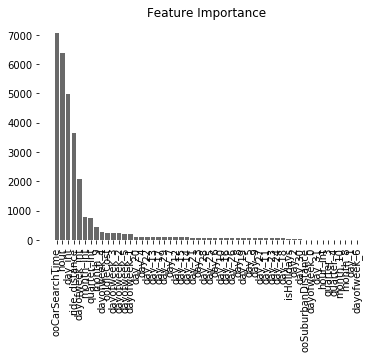

In [78]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [79]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

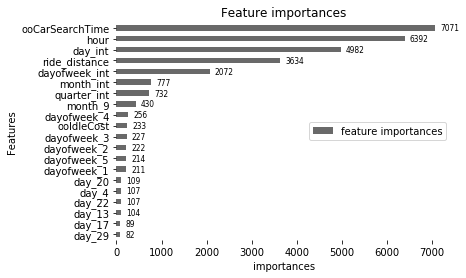

In [80]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()

### ExtraTreesRegressor

In [81]:
etr = ExtraTreesRegressor(random_state=1)

In [82]:
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [83]:
y_pred = etr.predict(X_test)

In [84]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 423.55


In [85]:
mean_absolute_percentage_error(y_test, y_pred)

11.864174312311789